<a href="https://colab.research.google.com/github/gecco-evojax/evojax/blob/main/notebooks/WaterWorld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Jan  6 23:48:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 495.46       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    37W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# @title Install Packages

from IPython.display import clear_output

!pip install git+https://github.com/gecco-evojax/evojax.git@main

clear_output()

In [3]:
import time
import numpy as np
from IPython.display import Image

import jax
import jax.numpy as jnp
from jax import random

from evojax import SimManager
from evojax import Trainer
from evojax.algo import PGPE
from evojax.policy import MLPPolicy
from evojax.task.waterworld import WaterWorld
from evojax.util import create_logger

log_dir = '/tmp/water_world'
logger = create_logger(name='WaterWorldDemo', log_dir=log_dir)
logger.info('jax.devices(): {}'.format(jax.devices()))

absl: 2022-01-06 23:48:43,761 [INFO] Starting the local TPU driver.
absl: 2022-01-06 23:48:43,772 [INFO] Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: local://
absl: 2022-01-06 23:48:44,922 [INFO] Unable to initialize backend 'tpu': Invalid argument: TpuPlatform is not available.
WaterWorldDemo: 2022-01-06 23:48:44,928 [INFO] jax.devices(): [GpuDevice(id=0, process_index=0)]


total_reward=1.0


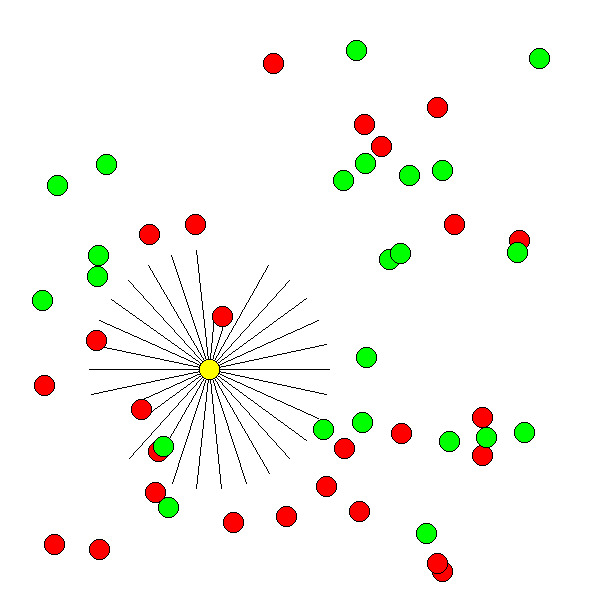

In [4]:
# @title Preview of the task
# @markdown This can take some time because it involves rendering.

max_steps = 500
train_env = WaterWorld(max_steps=max_steps, test=False)
valid_env = WaterWorld(max_steps=max_steps, test=True)

reset_fn = jax.jit(valid_env.reset)
step_fn = jax.jit(valid_env.step)

key = random.PRNGKey(0)
state = reset_fn(key[None, :])
total_reward = 0
screens = []
action = jnp.array([[0.25, 0.25, 0.25, 0.25]])  # Probs for 4 directions.
for _ in range(max_steps):
    state, reward, done = step_fn(state, action)
    total_reward = total_reward + reward
    screens.append(WaterWorld.render(state))
print('total_reward={}'.format(total_reward[0]))
screens[0].save(
    'waterworld_rand_policy.gif', save_all=True, append_images=screens[1:],
    duration=40, loop=0)
Image(open('waterworld_rand_policy.gif','rb').read())

# Learning to solve the task

In [5]:
# @title Set hyper-parameters
pop_size = 256  # @param
center_lr = 0.014  # @param
stdev_lr = 0.088  # @param
init_stdev = 0.069  # @param
max_iters = 500  # @param
seed = 42  # @param
n_repeats = 32  # @param

In [6]:
# @title Training

policy = MLPPolicy(
    input_dim=train_env.obs_shape[0],
    output_dim=train_env.act_shape[0],
    hidden_dims=[100, ],
    output_act_fn='softmax',
    logger=logger,
)
solver = PGPE(
    pop_size=pop_size,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=center_lr,
    init_stdev=init_stdev,
    stdev_learning_rate=stdev_lr,
    seed=seed,
)
trainer = Trainer(
    policy=policy,
    solver=solver,
    train_task=train_env,
    test_task=valid_env,
    max_iter=max_iters,
    log_interval=10,
    test_interval=50,
    n_repeats=n_repeats,
    n_evaluations=100,
    seed=seed,
    log_dir=log_dir,
    logger=logger,
    normalize_obs=False,
)
_ = trainer.run()

WaterWorldDemo: 2022-01-06 23:51:34,669 [INFO] MLPPolicy.num_params = 15704
WaterWorldDemo: 2022-01-06 23:51:34,913 [INFO] Start to train for 500 iterations.
WaterWorldDemo: 2022-01-06 23:53:06,339 [INFO] Iter=10, size=256, max=1.2188, avg=0.0170, min=-1.1250, std=0.3923
WaterWorldDemo: 2022-01-06 23:53:22,197 [INFO] Iter=20, size=256, max=1.3750, avg=0.2622, min=-0.7500, std=0.3900
WaterWorldDemo: 2022-01-06 23:53:38,053 [INFO] Iter=30, size=256, max=2.0938, avg=0.8936, min=-0.3125, std=0.4708
WaterWorldDemo: 2022-01-06 23:53:54,004 [INFO] Iter=40, size=256, max=3.7812, avg=1.7413, min=-0.1562, std=0.7103
WaterWorldDemo: 2022-01-06 23:54:09,898 [INFO] Iter=50, size=256, max=4.0000, avg=2.1586, min=0.5000, std=0.6980
WaterWorldDemo: 2022-01-06 23:55:21,105 [INFO] [TEST] Iter=50, #tests=100, max=13.0000 avg=3.2400, min=-3.0000, std=3.1847
WaterWorldDemo: 2022-01-06 23:55:37,140 [INFO] Iter=60, size=256, max=4.6562, avg=3.1322, min=0.8750, std=0.7305
WaterWorldDemo: 2022-01-06 23:55:53,0

total_reward=11.0


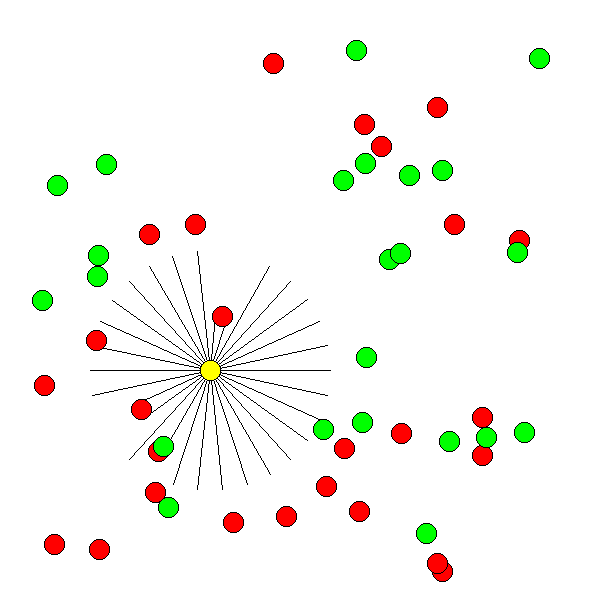

In [7]:
# @title Visualize the trained policy

action_fn = jax.jit(policy.get_actions)
best_params = solver.best_params[None, :]

key = random.PRNGKey(0)
state = reset_fn(key[None, :])
total_reward = 0
screens = []
for _ in range(max_steps):
    action = action_fn(state.obs, best_params)
    state, reward, done = step_fn(state, action)
    total_reward = total_reward + reward
    screens.append(WaterWorld.render(state))
print('total_reward={}'.format(total_reward[0]))
screens[0].save(
    'waterworld_trained_policy.gif', save_all=True, append_images=screens[1:],
    duration=40, loop=0)
Image(open('waterworld_trained_policy.gif','rb').read())